In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Nous utilisons cette fonction pour la reproductibilité des résultats
def set_seed():
    seed = 1952752
    random.seed(seed)
    np.random.seed(seed)
    cv2.setRNGSeed(seed)

In [3]:
# Pour HOG, nous allons vouloir resize toutes les images à la même dimension, 
# dans le but d'avoir le même nombre de descripteur pour chaque image
# Nous avons opter pour une grandeur arbitraire de 400x400
target_size = (400,400)

def read_image(path, target_size = target_size, resize=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if resize : 
        return cv2.resize(img, target_size)
    return img

In [4]:
file_names = os.listdir('./data/database/')
images = [ read_image('./data/database/'+str(path), resize=True) for path in file_names ]

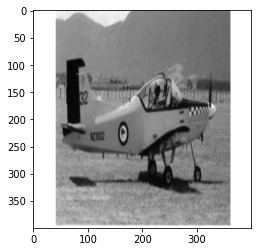

In [5]:
plt.figure()
plt.imshow(images[0], cmap='gray')
plt.show()

## HOG

In [6]:
# On commence par calculer les descripteurs pour chaque images de la base de données
hog = cv2.HOGDescriptor()
hogs = [ hog.compute(im) for im in images ]

In [7]:
# Une fonction simple pour calculer 
def top_n(name, sorted_indexes, top_n, file_names=file_names):
    count = 0
    for img_index in sorted_indexes[:top_n] :
        if file_names[img_index].startswith(name):
            count+=1
    return count/top_n

In [8]:
# Fonction simple pour calculer le hog et l'accuracy pour chaque query
# La fonction prend en entré une fonction de distance qu'il utilise
# pour trouver les images les plus similaires
def calculate_accuracy_hog(database_hogs, distance_function, cropped=False):
    set_seed()
    top1 = 0
    top3 = 0
    top5 = 0
    query_all = []
    sorted_indexes_all = []
    distances_all = []
    names = ["airplane", "ball", "car", "cat", "dolphin", "face", "lotus", "pickles"]
    suffix = '_query.jpg'
    if cropped :
        suffix = '_query_cropped.jpg'
    for name in names:
        query = read_image('./data/'+str(name)+str(suffix), resize = True)
        query_all.append(query)
        query_hog = hog.compute(query)
        distances = distance_function(database_hogs, query_hog)
        distances_all.append(distances)
        sorted_indexes = np.argsort(distances)
        sorted_indexes_all.append(sorted_indexes)
        top1 += top_n(name, sorted_indexes, 1)
        top3 += top_n(name, sorted_indexes, 3)
        top5 += top_n(name, sorted_indexes, 5)
    return top1/len(names), top3/len(names), top5/len(names), sorted_indexes_all, query_all, distances_all

In [9]:
def euclidean_distance(database_hogs, query_hog):
    return [np.linalg.norm(database-query_hog) for database in database_hogs]

def cosine_distance(database_hogs, query_hog):
    return [cosine_similarity(database.reshape(1, -1),query_hog.reshape(1, -1))[0][0] for database in database_hogs]

def scalar_product(database_hogs, query_hog):
    return [np.dot(database,query_hog) for database in database_hogs]

def correlation(database_hogs, query_hog):
    return [np.correlate(database,query_hog)[0] for database in database_hogs]

In [10]:
top1, top3, top5, sorted_images_all, query_all, distances_all = calculate_accuracy_hog(hogs, euclidean_distance)

In [11]:
print("Top 1 accuracy is : " + str(top1*100) + "%")
print("Top 3 accuracy is : " + str(top3*100) + "%")
print("Top 5 accuracy is : " + str(top5*100) + "%")

Top 1 accuracy is : 75.0%
Top 3 accuracy is : 58.33333333333333%
Top 5 accuracy is : 52.5%


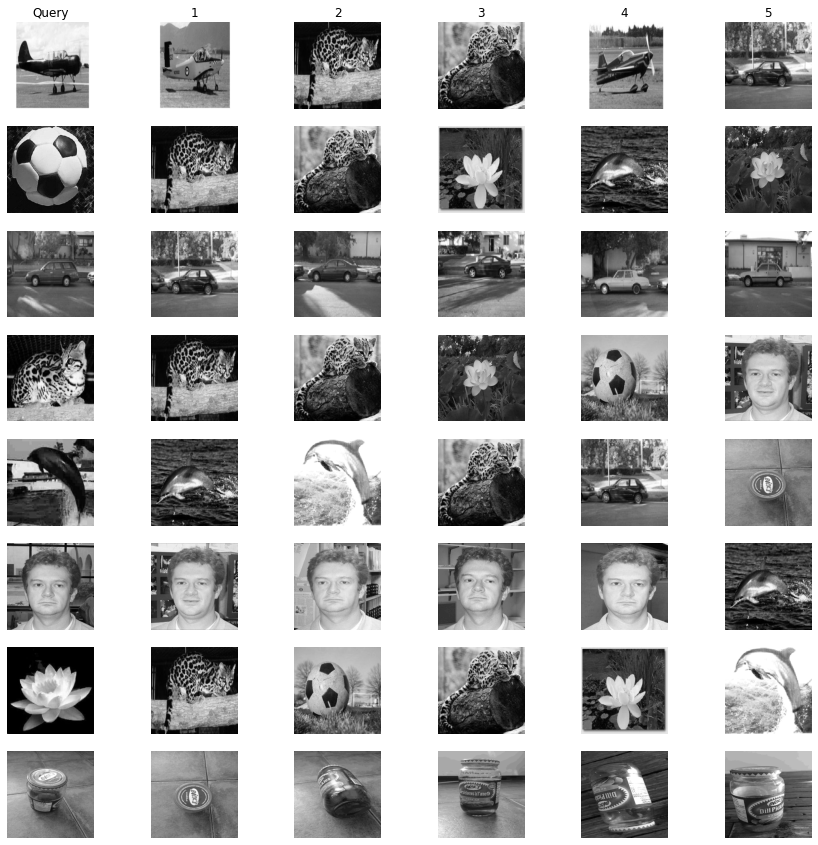

In [12]:
# On imprime les queries et les images les plus similaires selon HOG
fig = plt.figure(figsize=[15, 15])
rows = 8
columns = 6
current_subplot = 0

for current_row in range(8):
    current_subplot += 1
    fig.add_subplot(rows, columns, current_subplot)
    plt.imshow(query_all[current_row], cmap='gray')
    plt.axis("off")
    if current_row == 0 :
        plt.title("Query")

    for i in range(5):
        current_subplot += 1
        fig.add_subplot(rows, columns, current_subplot)
        plt.imshow(images[sorted_images_all[current_row][i]], cmap='gray')
        plt.axis("off")
        
        if current_row == 0 :
            plt.title(i+1)

# SIFT

In [13]:
# Cette fois-ci, on ne veut pas resize les images,
# car ce n'est pas nécessaire avec SIFT
file_names = os.listdir('./data/database/')
images = [ read_image('./data/database/'+str(path)) for path in file_names ]

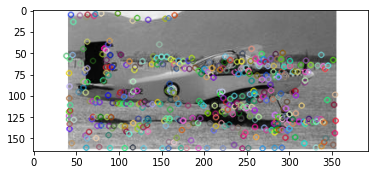

In [14]:
# Un exemple de la détection de keypoints avec SIFT
query1 = read_image('./data/database/airplane_1.jpg')
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(query1,None)
img1 = cv2.drawKeypoints(query1, kp1, query1)
plt.figure()
plt.imshow(img1)
plt.show()

In [15]:
# La taille et nombre des descripteurs
des1.shape

(452, 128)

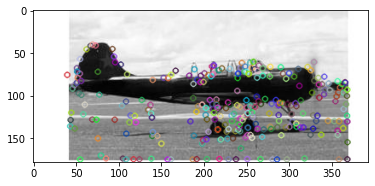

In [16]:
# Un second exemple de SIFT
query2 = read_image('./data/airplane_query.jpg')
kp2, des2 = sift.detectAndCompute(query2,None)
img2 = cv2.drawKeypoints(query2, kp2, query2)
plt.figure()
plt.imshow(img2)
plt.show()

In [17]:
# On peut remarquer que la le nombre de keypoints et de descripteurs change en fonction de l'image
des2.shape

(290, 128)

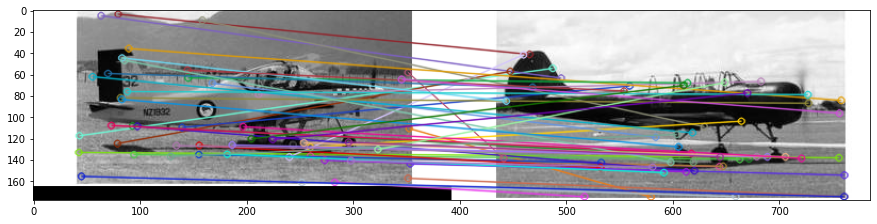

In [18]:
#feature matching, matcher les keypoints d'une image et d'une autre
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

plt.figure(figsize=[15, 15])
img3 = cv2.drawMatches(query1, kp1, query2, kp2, matches[:50], query2, flags=2)
plt.imshow(img3)
plt.show()

In [19]:
# Le nombre de matchs de keypoints entre deux images peut être utilisé comme indicateur de similarité
print(len(matches))

73


In [20]:
# Création des descriptors pour chaque images de la base de données
sift = cv2.SIFT_create()
database_descriptors = [ sift.detectAndCompute(im,None)[1] for im in images ]

In [21]:
# Fonction simple pour calculer le SIFT et l'accuracy pour chaque query
# La fonction prend en entré une fonction de matching qu'il utilise
# pour trouver les images les plus similaires
def calculate_accuracy_sift(database_desc, matching_method, cropped=False):
    set_seed()
    top1 = 0
    top3 = 0
    top5 = 0
    query_all = []
    sorted_indexes_all = []
    names = ["airplane", "ball", "car", "cat", "dolphin", "face", "lotus", "pickles"]
    suffix = '_query.jpg'
    if cropped :
        suffix = '_query_cropped.jpg'
    for name in names:
        query = read_image('./data/'+str(name)+str(suffix))
        query_all.append(query)
        query_desc = sift.detectAndCompute(query, None)[1]
        
        distances = matching_method(query_desc, database_desc)
        
        sorted_indexes = np.argsort(distances)[::-1]
        sorted_indexes_all.append(sorted_indexes)
        top1 += top_n(name, sorted_indexes, 1)
        top3 += top_n(name, sorted_indexes, 3)
        top5 += top_n(name, sorted_indexes, 5)
    return top1/len(names), top3/len(names), top5/len(names), sorted_indexes_all, query_all

In [37]:
# https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-2-c4350274be2b
def calculate_matching(desc1, desc2):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5),dict())
    matches = flann.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)
    return good

def BruteForceMatching(query_desc, database_desc):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    return [ len(bf.match(query_desc,desc)) for desc in database_desc ]

def FLANNMatching(query_desc, database_desc):
    # https://adnanmushtaq5.medium.com/sift-algorithm-for-image-comparison-4b17362d521 
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5),dict())
    return [ len(flann.knnMatch(query_desc, desc, k=2)) for desc in database_desc ]
    
def FLANNMatching_good_only(query_desc, database_desc):
    return [ len(calculate_matching(query_desc, desc)) for desc in database_desc ]

In [38]:
top1, top3, top5, sorted_images_all, query_all = calculate_accuracy_sift(database_descriptors, BruteForceMatching)

In [39]:
print("Top 1 accuracy is : " + str(top1*100) + "%")
print("Top 3 accuracy is : " + str(top3*100) + "%")
print("Top 5 accuracy is : " + str(top5*100) + "%")

Top 1 accuracy is : 12.5%
Top 3 accuracy is : 12.5%
Top 5 accuracy is : 12.5%


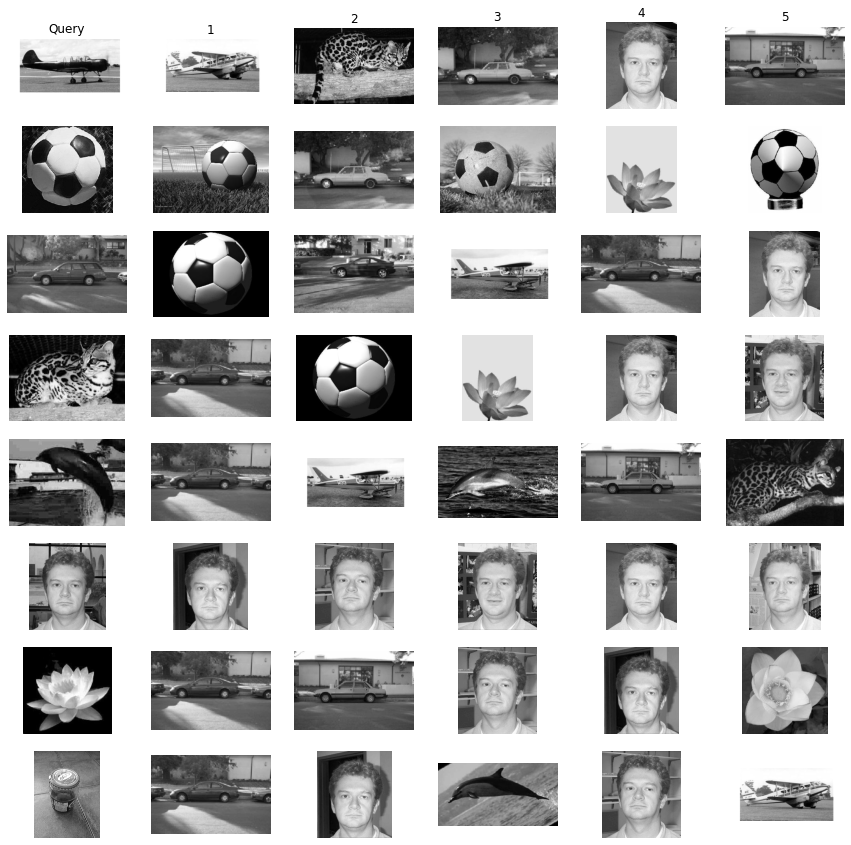

In [25]:
# On imprime les queries et les images les plus similaires selon HOG
fig = plt.figure(figsize=[15, 15])
rows = 8
columns = 6
current_subplot = 0

for current_row in range(8):
    current_subplot += 1
    fig.add_subplot(rows, columns, current_subplot)
    plt.imshow(query_all[current_row], cmap='gray')
    plt.axis("off")
    if current_row == 0 :
        plt.title("Query")

    for i in range(5):
        current_subplot += 1
        fig.add_subplot(rows, columns, current_subplot)
        plt.imshow(images[sorted_images_all[current_row][i]], cmap='gray')
        plt.axis("off")
        
        if current_row == 0 :
            plt.title(i+1)

## Bounding boxes

On va créer des boites englobantes pour chaque image pour l'isoler de son background et crop seulement la région importante.

In [26]:
def bounding_box_crop(images):
    bb = [ cv2.selectROI(img) for img in images]
    croped_images = [ 
        images[i][int(bb[i][1]):int(bb[i][1]+bb[i][3]), int(bb[i][0]):int(bb[i][0]+bb[i][2])] 
        for i in range(len(images))
    ]
    return croped_images

In [25]:
# Les images de pickles sont beaucoup trop grande pour être afficher sur mon moniteur
# alors je la resize avant de sélectionner la zone englobante
pickles = [ cv2.resize(img, (700, 1000)) for img in images[-5:] ]
images[-5:] = pickles

In [39]:
# Pour redéfinir bounding boxes, cependant elle sont déjà définit
# et donc ce n'est pas nécessaire à chaque fois qu'on roule le code

#cropped_images = bounding_box_crop(images)

In [40]:
def save_images(cropped_images, queries=False):
    names = ["airplane", "ball", "car", "cat", "dolphin", "face", "lotus", "pickles"]
    for i in range(len(cropped_images)):
        if not queries : 
            name_index = np.floor(i / 5)
            cv2.imwrite("./data/database_cropped/"+str(names[int(name_index)])+ "_"+ str(i%5)+".jpg", cropped_images[i])
        else :
            result = cv2.imwrite("./data/"+str(names[i])+ "_query_cropped.jpg", cropped_images[i])

In [41]:
# Seulement rouler cette fonction lorsque necessaire
# tout deverait déjà être sauvegarder dans les fichiers sinon

#save_images(cropped_images)

In [42]:
names = ["airplane", "ball", "car", "cat", "dolphin", "face", "lotus", "pickles"]
queries = [read_image('./data/'+str(name)+'_query.jpg') for name in names]

In [43]:
queries[-1] = cv2.resize(queries[-1], (700, 1000))

In [44]:
# Seulement rouler cette fonction lorsque necessaire
# tout deverait déjà être sauvegarder dans les fichiers sinon

# cropped_queries = bounding_box_crop(queries)
# save_images(cropped_queries, queries = True)

## HOG with Bounding boxes

In [46]:
file_names = os.listdir('./data/database_cropped/')
images_cropped = [ read_image('./data/database_cropped/'+str(path), resize=True) for path in file_names ]

In [48]:
# Création du HOG pour chaque images cropped de la base de données
hog = cv2.HOGDescriptor()
hogs_cropped = [ hog.compute(im) for im in images_cropped ]

In [49]:
top1, top3, top5, sorted_images_all, query_all, _ = calculate_accuracy_hog(hogs_cropped, euclidean_distance, cropped=True)

In [50]:
print("Top 1 accuracy is : " + str(top1*100) + "%")
print("Top 3 accuracy is : " + str(top3*100) + "%")
print("Top 5 accuracy is : " + str(top5*100) + "%")

Top 1 accuracy is : 50.0%
Top 3 accuracy is : 41.66666666666667%
Top 5 accuracy is : 40.0%


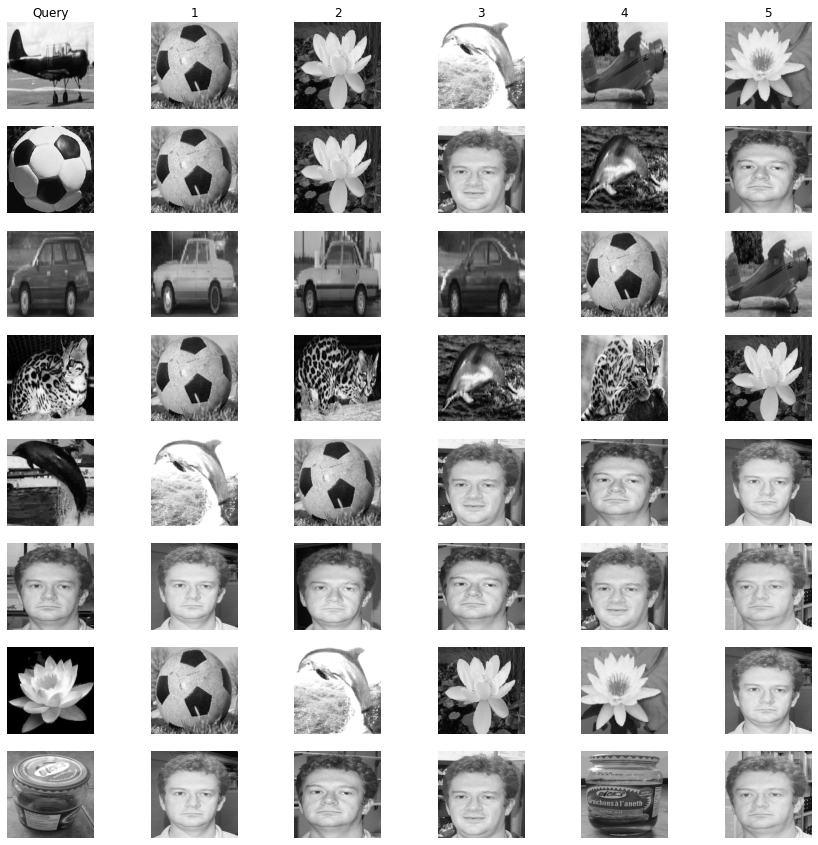

In [52]:
# On imprime les queries et les images cropped les plus similaires selon HOG
fig = plt.figure(figsize=[15, 15])
rows = 8
columns = 6
current_subplot = 0

for current_row in range(8):
    current_subplot += 1
    fig.add_subplot(rows, columns, current_subplot)
    plt.imshow(query_all[current_row], cmap='gray')
    plt.axis("off")
    if current_row == 0 :
        plt.title("Query")

    for i in range(5):
        current_subplot += 1
        fig.add_subplot(rows, columns, current_subplot)
        plt.imshow(images_cropped[sorted_images_all[current_row][i]], cmap='gray')
        plt.axis("off")
        
        if current_row == 0 :
            plt.title(i+1)

## SIFT with Bounding boxes

In [54]:
file_names = os.listdir('./data/database_cropped/')
images_cropped = [ read_image('./data/database_cropped/'+str(path)) for path in file_names ]

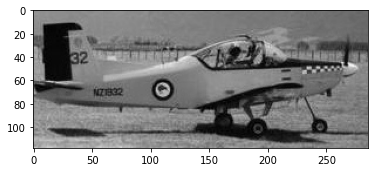

In [55]:
plt.figure()
plt.imshow(images_cropped[0], cmap='gray')
plt.show()

In [56]:
# Création des descriptors pour chaque images cropped de la base de données
sift = cv2.SIFT_create()
database_cropped_descriptors = [ sift.detectAndCompute(im,None)[1] for im in images_cropped ]

In [59]:
top1, top3, top5, sorted_images_all, query_all = calculate_accuracy_sift(database_cropped_descriptors, FLANNMatching_good_only, cropped=True)

In [60]:
print("Top 1 accuracy is : " + str(top1*100) + "%")
print("Top 3 accuracy is : " + str(top3*100) + "%")
print("Top 5 accuracy is : " + str(top5*100) + "%")

Top 1 accuracy is : 25.0%
Top 3 accuracy is : 33.33333333333333%
Top 5 accuracy is : 27.500000000000004%


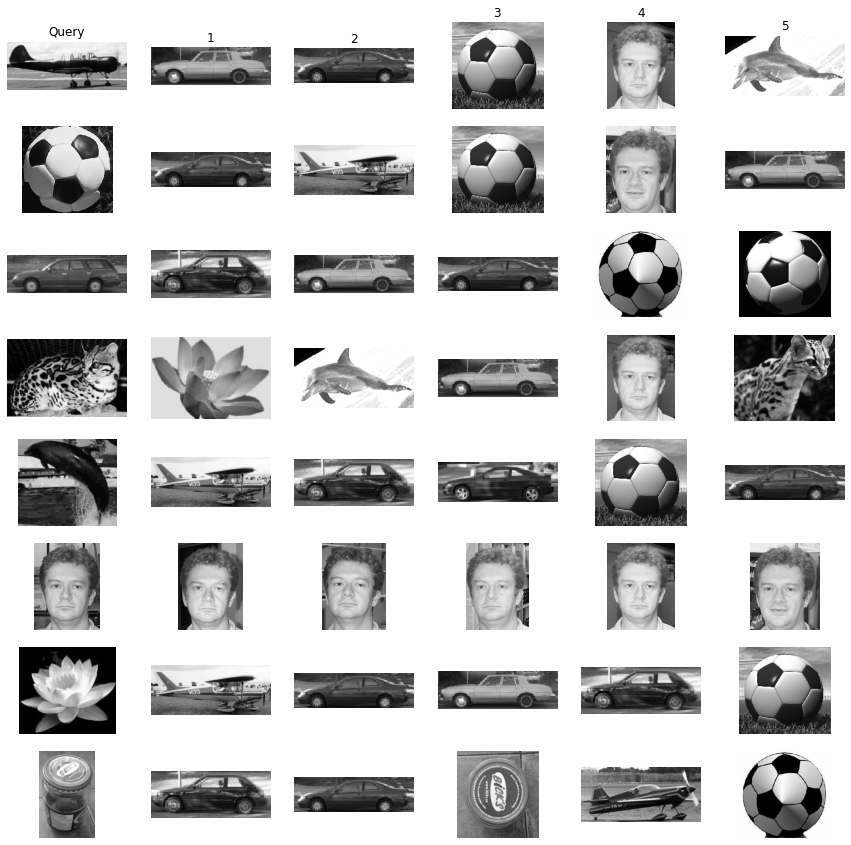

In [62]:
# On imprime les queries et les images cropped les plus similaires selon SIFT
fig = plt.figure(figsize=[15, 15])
rows = 8
columns = 6
current_subplot = 0

for current_row in range(8):
    current_subplot += 1
    fig.add_subplot(rows, columns, current_subplot)
    plt.imshow(query_all[current_row], cmap='gray')
    plt.axis("off")
    if current_row == 0 :
        plt.title("Query")

    for i in range(5):
        current_subplot += 1
        fig.add_subplot(rows, columns, current_subplot)
        plt.imshow(images_cropped[sorted_images_all[current_row][i]], cmap='gray')
        plt.axis("off")
        
        if current_row == 0 :
            plt.title(i+1)

## Strawberry 

In [63]:
file_names = os.listdir('./data/database/')
images = [ read_image('./data/database/'+str(path), resize=True) for path in file_names ]

In [64]:
hog = cv2.HOGDescriptor()
hogs = [ hog.compute(im) for im in images ]

In [65]:
np.mean(distances_all)

350.90704

In [66]:
np.mean(np.sort(distances_all, axis=1), axis=0)[2]

318.21075

In [67]:
def calculate_accuracy_hog_strawberry(database_hogs, distance_function):
    set_seed()
    query = read_image('./data/strawberry_query.jpg', resize = True)
    query_hog = hog.compute(query)
    distances = distance_function(database_hogs, query_hog)
    return distances

In [68]:
strawberry_distances = calculate_accuracy_hog_strawberry(hogs, euclidean_distance)

In [69]:
np.sort(strawberry_distances)

array([308.68433, 309.45975, 318.4292 , 321.06216, 322.15894, 323.04657,
       324.86707, 325.1175 , 326.53876, 334.1281 , 336.53793, 336.92117,
       337.38123, 337.83768, 338.62122, 338.80753, 342.42435, 342.5936 ,
       343.02475, 343.06305, 343.33212, 343.78256, 344.46924, 345.93793,
       346.9086 , 348.68884, 349.75293, 351.24957, 351.73212, 355.12524,
       360.31015, 360.54086, 362.44885, 365.54495, 368.45697, 371.10498,
       374.13382, 375.67023, 377.27832, 382.7146 ], dtype=float32)

In [70]:
sorted_indexes = np.argsort(strawberry_distances)

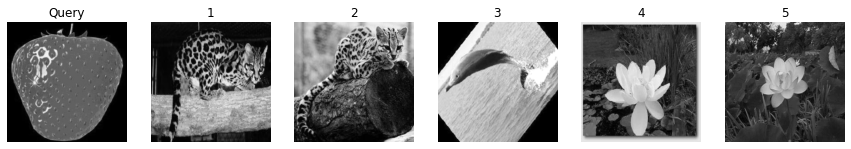

In [71]:
fig = plt.figure(figsize=[15, 15])
rows = 1
columns = 6
current_subplot = 0

current_subplot += 1
fig.add_subplot(rows, columns, current_subplot)
plt.imshow(read_image('./data/strawberry_query.jpg', resize = True), cmap='gray')
plt.axis("off")
plt.title("Query")

for i in range(5):
    current_subplot += 1
    fig.add_subplot(rows, columns, current_subplot)
    plt.imshow(images[sorted_indexes[i]], cmap='gray')
    plt.axis("off")
    plt.title(i+1)